# Customer churn in telecommunications company.

The telecommunications company wants to minimize customer churn. To do this, their employees will start offering promo codes and special deals to anyone planning to cancel their services. To identify such users in advance, the company needs a model that predicts whether a subscriber will terminate their contract. The operator's team has gathered personal data about some customers, as well as information about their tariffs and services.

**Task:** Train a model on this data to predict customer churn.

**Service Description:**
The operator provides two main types of services:
- Fixed-line telephone service, which allows multiple lines to be connected simultaneously.
- Internet service, which can be connected through either DSL (digital subscriber line) or fiber optic cable.

In addition, subscribers have access to various services:
- Internet security: antivirus (Device Protection) and blocking of dangerous websites (Online Security).
- Dedicated technical support line (Tech Support).
- Cloud storage for data backup (Online Backup).
- Streaming TV (Streaming TV) and a catalog of movies (Streaming Movies).

Customers can pay for services on a monthly basis or once every 1-2 years. Various payment methods are available, as well as the option to receive electronic invoices.

**Data Description:**
The data is stored in a PostgreSQL database and consists of several tables:
- *contract* - information about contracts.
- *personal* - personal customer data.
- *internet* - information about internet services.
- *phone* - information about phone services.

The contract information is up-to-date as of February 1, 2020.

# Connecting to the database and loading SQL tables.

### Installing software packages and importing necessary libraries.

In [ ]:
!pip install ydata-profiling --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not

In [ ]:
!pip install catboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.0 MB/s eta 0:00:00


In [ ]:
!pip install --upgrade scikit-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 28.7 MB/s eta 0:00:00


In [ ]:
!pip install phik --quiet

In [ ]:
!pip install tqdm --quiet

In [ ]:
import pandas as pd
import numpy as np

import itertools
import math

import matplotlib.pyplot as plt
import seaborn as sns

import sqlalchemy

from sqlalchemy import create_engine, text

from ydata_profiling import ProfileReport

from tqdm.notebook import tqdm_notebook
from sklearn.utils import parallel_backend

from numpy.random import RandomState
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score

from catboost import CatBoostClassifier

import psycopg2

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch.utils.data import DataLoader, TensorDataset

import copy
import random

import phik
from phik import resources, report

from tqdm import tqdm

SEED = 171023
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import warnings
warnings.filterwarnings('ignore')

### Creating a configuration for connecting to the database.

In [ ]:
db_config = {
'user': '__________',
'pwd': '______________',
'host': '_______________________',
'port': 6432,
'db': '___________________'
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

### Creating a connection.

In [ ]:
con = psycopg2.connect(
    host=db_config['host'],
    port=db_config['port'],
    database=db_config['db'],
    user=db_config['user'],
    password=db_config['pwd']
)

### Loading the `contract` table and saving it in a dataframe.

In [ ]:
query = '''
SELECT *
FROM telecom.contract;
'''

contract = pd.read_sql_query(query, con=con)

### Loading the `personal` table and saving it in a dataframe.

In [ ]:
query = '''
SELECT *
FROM telecom.personal;
'''

personal = pd.read_sql_query(query, con=con)

### Loading the `internet` table and saving it in a dataframe.

In [ ]:
query = '''
SELECT *
FROM telecom.internet;
'''

internet = pd.read_sql_query(query, con=con)

### Loading the `phone` table and saving it in a dataframe.

In [ ]:
query = '''
SELECT *
FROM telecom.phone;
'''

phone = pd.read_sql_query(query, con=con)

## Exploratory data analysis and data preprocessing.

### Exploring and preprocessing the `contract` dataframe.

#### Initial data exploration.

In [ ]:
# Displaying 5 rows of the `contract` dataframe
contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3596,1104-FEJAM,2019-09-10,None,Month-to-month,No,Electronic check,64.40,1802.15
4981,8706-HRADD,2019-02-22,None,Month-to-month,Yes,Mailed check,43.55,1011.50
909,4112-LUEIZ,2019-06-05,2020-01-01,Month-to-month,Yes,Electronic check,89.50,863.10
737,2691-NZETQ,2019-06-29,2020-01-01,Month-to-month,Yes,Electronic check,85.35,758.60
4547,8707-RMEZH,2019-03-02,None,One year,No,Credit card (automatic),87.30,6055.55


In [ ]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


**Preliminary findings:**
- Incorrect data types in the BeginDate and EndDate columns.
- Missing values in the EndDate and TotalCharges columns.
- Data in the PaperlessBilling column should be transformed for ease of subsequent machine learning.

In [ ]:
# Converting data types in the `BeginDate` and `EndDate` columns to datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])
contract['EndDate'] = pd.to_datetime(contract['EndDate'], errors='coerce')

#### Creating a new column for contract duration.

In [ ]:
# Setting the date for missing values in the `EndDate` column (i.e., for ongoing contracts) -
# the date when the contract information was last updated in the database.
default_date = pd.Timestamp('2020-02-01')

# Calculating the contract duration for each customer
contract['ContractDuration'] = (contract['EndDate'].fillna(default_date) - contract['BeginDate']).dt.days

contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration
0,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,NaN,0
1,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,NaN,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,479
3,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,NaN,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,279


#### Removing the BeginDate column.

In [ ]:
contract.drop('BeginDate', axis=1, inplace=True)

#### Creating and exploring a new column for daily customer expenses.

In [ ]:
# Creating a new column
contract['DailyCharges'] = (contract['TotalCharges'] / contract['ContractDuration']).astype('float64').round(1)

contract.sample(5)

,customerID,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration,DailyCharges
4215,9097-ZUBYC,NaT,Month-to-month,No,Bank transfer (automatic),48.80,664.40,314,2.1
5906,6726-NNFWD,NaT,Two year,No,Credit card (automatic),89.45,6435.25,177,36.4
4906,3982-JGSFD,NaT,One year,Yes,Credit card (automatic),20.35,695.85,257,2.7
4002,5226-NOZFC,NaT,Month-to-month,Yes,Electronic check,85.75,2146.50,413,5.2
111,4800-VHZKI,2020-01-01,Month-to-month,Yes,Mailed check,19.90,19.90,206,0.1


In [ ]:
# Exploring data for the `DailyCharges` column
contract['DailyCharges'].describe()

count    7032.000000
mean        8.768515
std        19.728024
min         0.000000
25%         1.400000
50%         4.900000
75%        13.100000
max      1421.300000
Name: DailyCharges, dtype: float64

In [ ]:
# Removing obvious outliers
contract = contract[contract['DailyCharges'] <= 200]

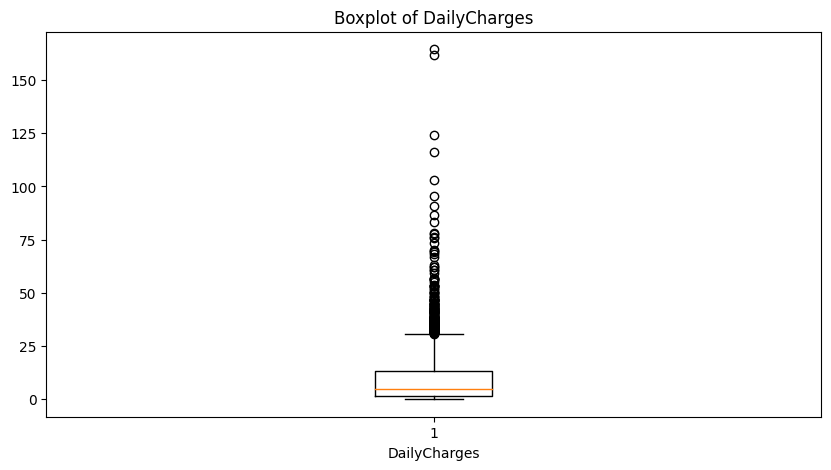

In [ ]:
# Creating a boxplot to detect outliers again
plt.figure(figsize=(10, 5))
plt.boxplot(contract['DailyCharges'])
plt.title('Boxplot of DailyCharges')
plt.xlabel('DailyCharges')
plt.show()

In [ ]:
# Calculating the upper boundary beyond which outliers begin
Q1 = contract['DailyCharges'].quantile(0.25)
Q3 = contract['DailyCharges'].quantile(0.75)
IQR = Q3 - Q1

upper_boundary = Q3 + 1.5 * IQR
print(f"Upper boundary for outlier detection: {upper_boundary}")

Upper boundary for outlier detection: 30.65


In [ ]:
# Removing the remaining outliers
contract = contract[contract['DailyCharges'] <= 31]

#### Transforming the EndDate column into the target variable column.

In [ ]:
contract['Churned'] = contract['EndDate'].notna().astype(int)

# Removing the original EndDate column
contract.drop('EndDate', axis=1, inplace=True)

In [ ]:
contract.head(5)

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractDuration,DailyCharges,Churned
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,479,0.2,1
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,279,0.5,1
5,9305-CDSKC,Month-to-month,Yes,Electronic check,99.65,820.50,310,2.6,1
8,7892-POOKP,Month-to-month,Yes,Electronic check,104.80,3046.05,188,16.2,1
12,0280-XJGEX,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,322,15.6,1


#### Removing rows with remaining missing values.

In [ ]:
contract.dropna(inplace=True)

#### Converting data format for machine learning optimization.

In [ ]:
contract['MonthlyCharges'] = contract['MonthlyCharges'].round().astype('int64')
contract['TotalCharges'] = contract['TotalCharges'].round().astype('int64')

In [ ]:
contract = contract.convert_dtypes()

#### Generating a report and drawing conclusions.

In [ ]:
# Creating a report
profile = ProfileReport(contract)

**Conclusions:**
- The dataset exhibits class imbalance: there are over twice as many current customers as there are churned customers.
- Two new features were created, and based on them, anomalous rows were identified and removed from the table.
- The most influential features on the target variable are Type, PaymentMethod, and MonthlyCharges, while contract duration has the least impact.

### Exploring and preprocessing the `personal` dataframe.

#### Initial data exploration.

In [ ]:
# Displaying 5 rows of the `personal` dataframe
personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
2671,4191-XOVOM,Male,0,No,No
1557,4672-FOTSD,Male,0,No,No
6419,3865-ZYKAD,Male,1,Yes,No
2521,5373-SFODM,Male,1,Yes,No
3594,9026-LHEVG,Female,0,No,No


In [ ]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


**Preliminary findings:**
- No missing values are present.
- Data in the Partner and Dependents columns should be transformed for ease of subsequent machine learning.

#### Transforming data in the SeniorCitizen column.

In [ ]:
personal['SeniorCitizen'] = personal['SeniorCitizen'].replace({1 : 'Yes', 0 : 'No'})

In [ ]:
# Creating a report
# profile = ProfileReport(personal)
# profile.to_notebook_iframe()

### Exploring and preprocessing the `internet` dataframe.

#### Initial data exploration.

In [ ]:
# Displaying 5 rows of the `internet` dataframe
internet.sample(5)

,c1,c2,c3,c4,c5,c6,c7,c8
2579,7774-OJSXI,Fiber optic,No,Yes,Yes,No,Yes,Yes
3186,9140-CZQZZ,DSL,Yes,Yes,No,Yes,Yes,Yes
3614,3680-CTHUH,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
1980,8869-LIHMK,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes
45,8012-SOUDQ,Fiber optic,No,Yes,No,No,Yes,No


In [ ]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB


**Conclusions:**
- No missing values are present.
- Column headers need to be adjusted.
- Data in the columns should be transformed for ease of subsequent machine learning.
- There are significantly fewer data in this table compared to the table with the target variable (not all customers use internet services).

#### Adjusting column headers.

In [ ]:
internet.columns = internet.iloc[0]
internet = internet.drop(internet.index[0])

### Exploring and preprocessing the `phone` dataframe.

#### Initial data exploration.

In [ ]:
# Displaying 5 rows of the `phone` dataframe
phone.sample(5)

,c1,c2
1538,9365-SRSZE,No
3243,6741-EGCBI,Yes
2731,1038-RQOST,No
4823,2498-XLDZR,No
5924,5012-YSPJJ,No


In [ ]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


**Conclusions:**
- No missing values are present.
- Column headers need to be adjusted.
- Data in the MultipleLines column should be transformed for ease of subsequent machine learning.
- There are significantly fewer data in this table compared to the table with the target variable (not all customers use landline phone services).


#### Adjusting column headers.

In [ ]:
phone.columns = phone.iloc[0]
phone = phone.drop(phone.index[0])

In [ ]:
phone.head()

,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


### Conclusions from the exploratory data analysis.

- The number of tables and the data contained in them align with the task description.
- A small number of missing values were identified and addressed.
- In the contract table, anomalies were identified and removed based on new features.
- As expected, not all customers use internet services and landline phone services.
- Some data with binary string values were preprocessed for ease of subsequent machine learning.
- Class imbalance was observed in the target variable.
- The tables are ready for merging.

### Merging tables.

In [ ]:
# Merging the contract and personal tables
data = pd.merge(contract, personal, on='customerID', how='left')

In [ ]:
# Adding the internet table to the resulting dataset
data = pd.merge(data, internet, on='customerID', how='left')

In [ ]:
# Adding the phone table to the resulting dataset
data = pd.merge(data, phone, on='customerID', how='left')

In [ ]:
# Checking the resulting dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6834 entries, 0 to 6833
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        6834 non-null   object 
 1   Type              6834 non-null   string 
 2   PaperlessBilling  6834 non-null   string 
 3   PaymentMethod     6834 non-null   string 
 4   MonthlyCharges    6834 non-null   Int64  
 5   TotalCharges      6834 non-null   Int64  
 6   ContractDuration  6834 non-null   Int64  
 7   DailyCharges      6834 non-null   Float64
 8   Churned           6834 non-null   Int64  
 9   gender            6834 non-null   object 
 10  SeniorCitizen     6834 non-null   object 
 11  Partner           6834 non-null   object 
 12  Dependents        6834 non-null   object 
 13  InternetService   5315 non-null   object 
 14  OnlineSecurity    5315 non-null   object 
 15  OnlineBackup      5315 non-null   object 
 16  DeviceProtection  5315 non-null   object 


### Data preprocessing in the merged dataframe.

#### Creating InternetUser and PhoneUser columns.

In [ ]:
# Creating the InternetUser column
data['InternetUser'] = np.where(data['InternetService'].isna(), 'No', 'Yes')

# Creating the PhoneUser column
data['PhoneUser'] = np.where(data['MultipleLines'].isna(), 'No', 'Yes')

#### Filling missing values.

In [ ]:
data.fillna('No', inplace=True)

#### Removing the customerID column.

In [ ]:
data.drop('customerID', axis=1, inplace=True)

In [ ]:
# Checking the obtained result
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6834 entries, 0 to 6833
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              6834 non-null   string 
 1   PaperlessBilling  6834 non-null   string 
 2   PaymentMethod     6834 non-null   string 
 3   MonthlyCharges    6834 non-null   Int64  
 4   TotalCharges      6834 non-null   Int64  
 5   ContractDuration  6834 non-null   Int64  
 6   DailyCharges      6834 non-null   Float64
 7   Churned           6834 non-null   Int64  
 8   gender            6834 non-null   object 
 9   SeniorCitizen     6834 non-null   object 
 10  Partner           6834 non-null   object 
 11  Dependents        6834 non-null   object 
 12  InternetService   6834 non-null   object 
 13  OnlineSecurity    6834 non-null   object 
 14  OnlineBackup      6834 non-null   object 
 15  DeviceProtection  6834 non-null   object 
 16  TechSupport       6834 non-null   object 


#### Converting data types.

In [ ]:
# Converting 'object' to 'string'
columns_to_convert = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
    'StreamingTV', 'StreamingMovies', 'MultipleLines', 'InternetUser',
    'PhoneUser'
]

for column in columns_to_convert:
    data[column] = data[column].astype('string')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6834 entries, 0 to 6833
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              6834 non-null   string 
 1   PaperlessBilling  6834 non-null   string 
 2   PaymentMethod     6834 non-null   string 
 3   MonthlyCharges    6834 non-null   Int64  
 4   TotalCharges      6834 non-null   Int64  
 5   ContractDuration  6834 non-null   Int64  
 6   DailyCharges      6834 non-null   Float64
 7   Churned           6834 non-null   Int64  
 8   gender            6834 non-null   string 
 9   SeniorCitizen     6834 non-null   string 
 10  Partner           6834 non-null   string 
 11  Dependents        6834 non-null   string 
 12  InternetService   6834 non-null   string 
 13  OnlineSecurity    6834 non-null   string 
 14  OnlineBackup      6834 non-null   string 
 15  DeviceProtection  6834 non-null   string 
 16  TechSupport       6834 non-null   string 


### Exploratory Data Analysis in the merged dataframe.

#### Visualizing the ratio of churned and retained customers for each feature.


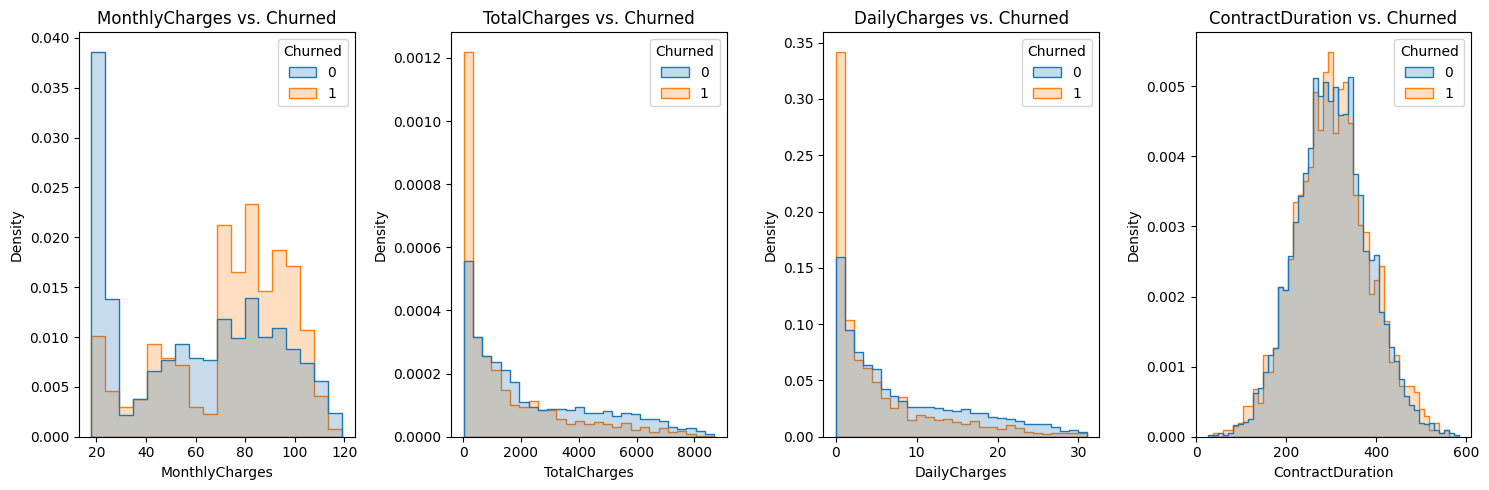

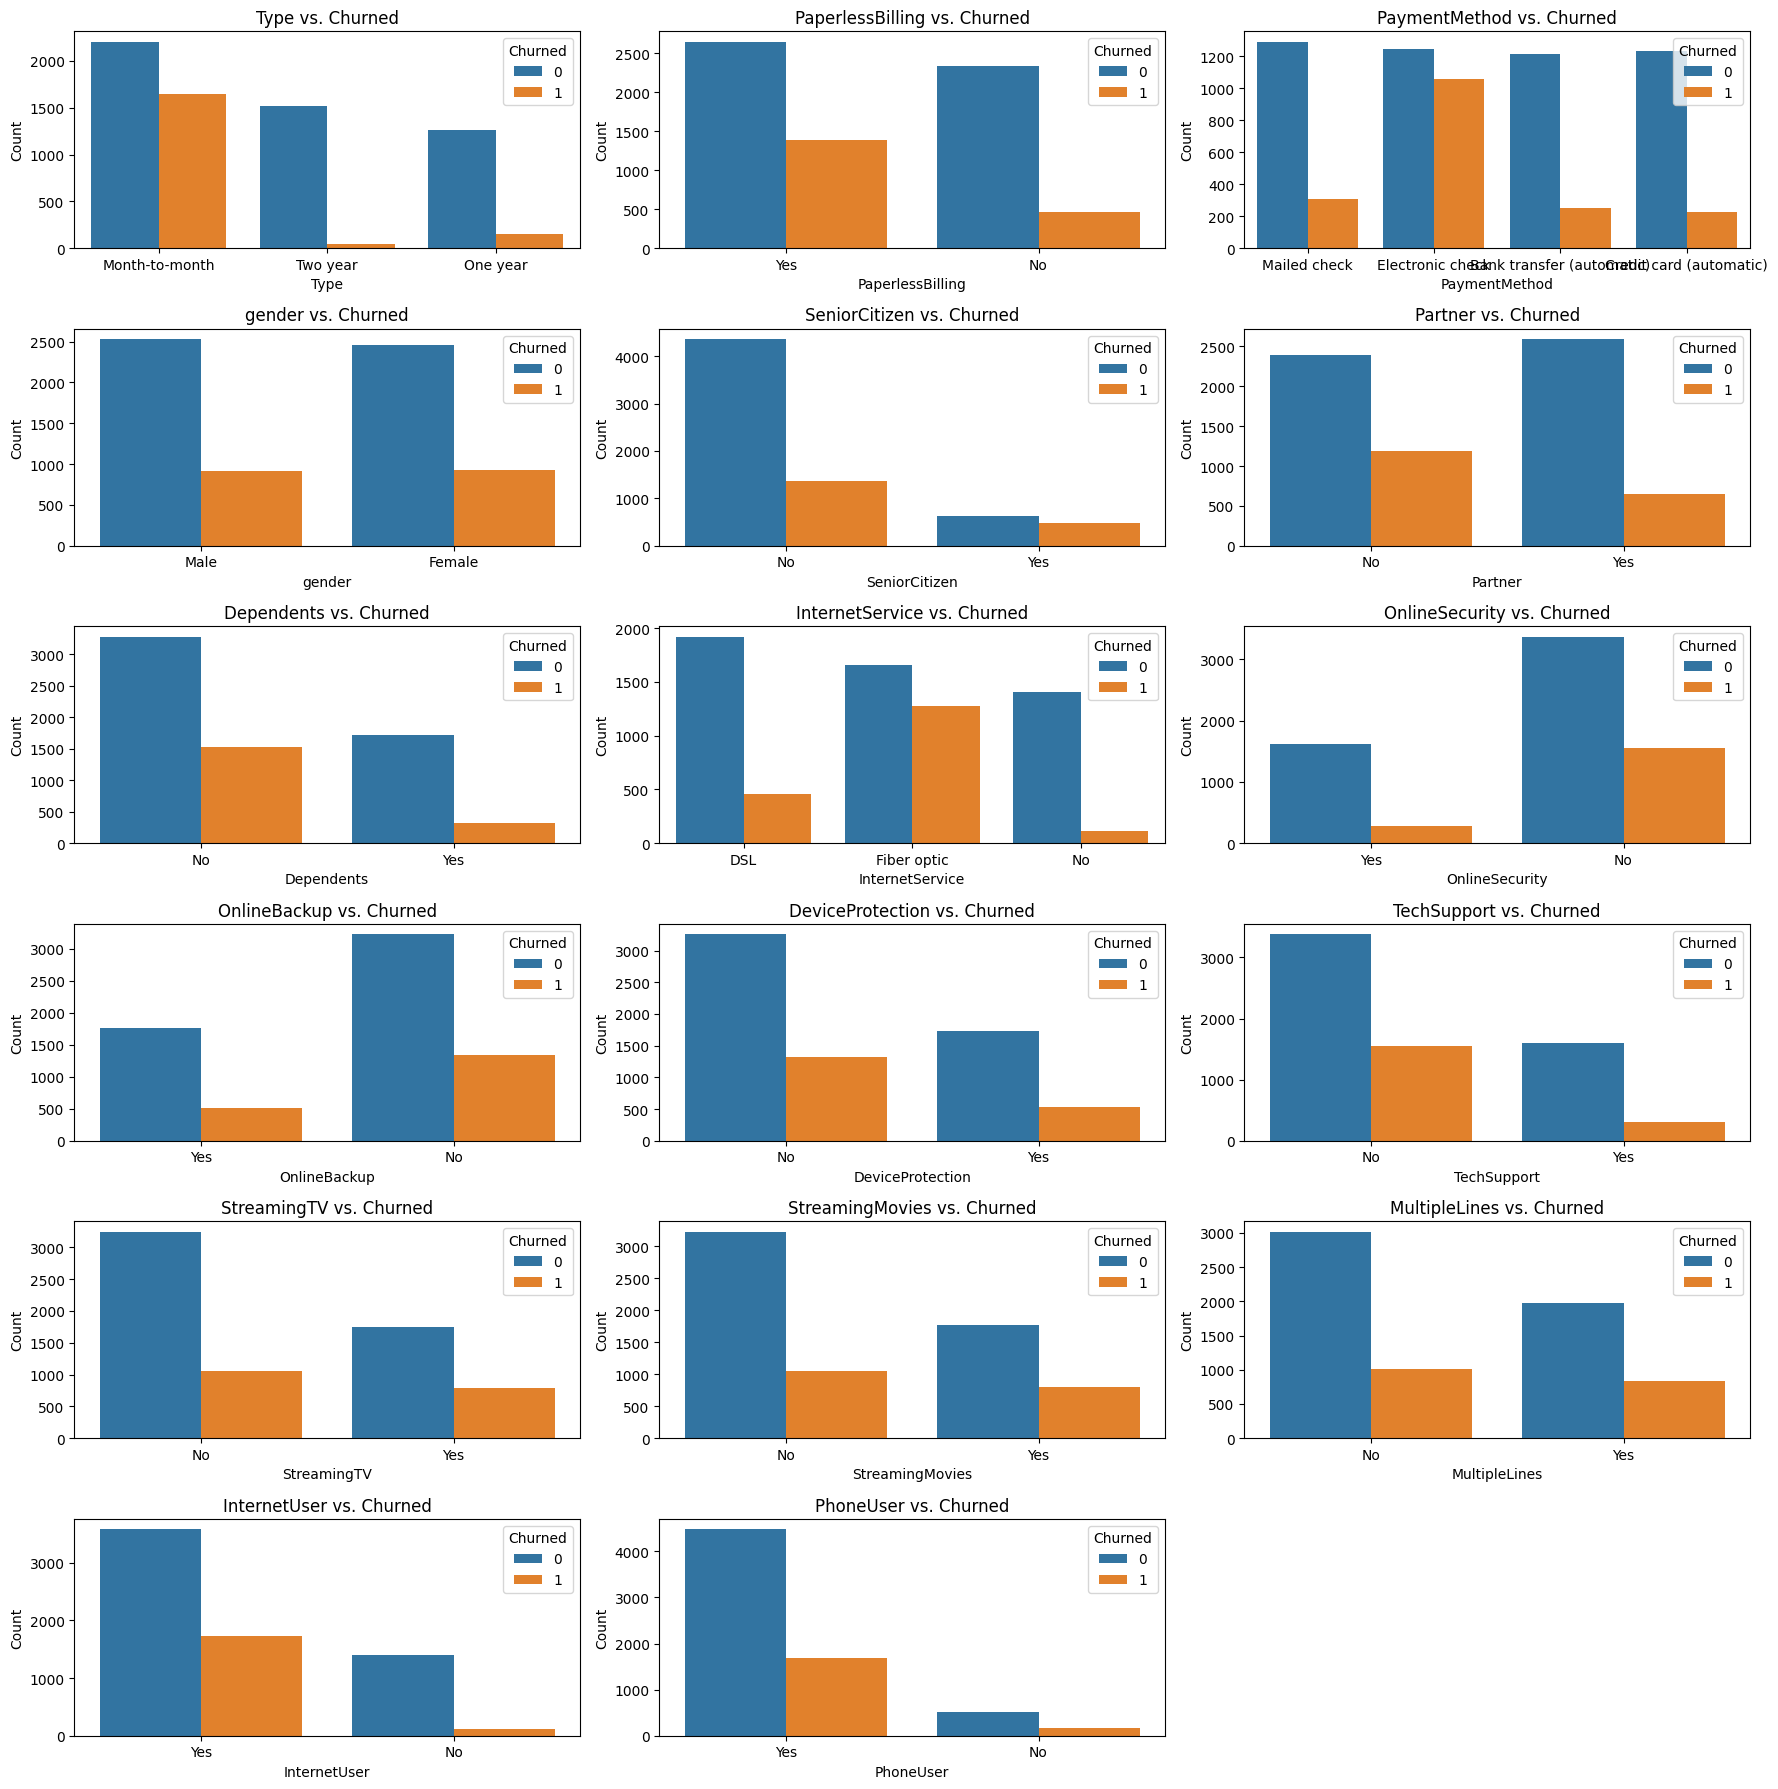

In [ ]:
# Visualizing information for numerical features
numerical_features = ['MonthlyCharges', 'TotalCharges', 'DailyCharges', 'ContractDuration']

fig, axes = plt.subplots(1, len(numerical_features), figsize=(15, 5))

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    sns.histplot(data=data, x=feature, hue='Churned', element='step', stat='density', common_norm=False, ax=ax)
    ax.set_title(f'{feature} vs. Churned')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

# Visualizing information for categorical features
categorical_features = [
    'Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'MultipleLines', 'InternetUser', 'PhoneUser'
]

rows = math.ceil(len(categorical_features) / 3)
fig, axes = plt.subplots(rows, 3, figsize=(18, rows * 3))

if rows == 1:
    axes = axes.reshape(-1)

for i, feature in enumerate(categorical_features):
    ax = axes[i // 3, i % 3]
    sns.countplot(data=data, x=feature, hue='Churned', ax=ax)
    ax.set_title(f'{feature} vs. Churned')
    ax.set_ylabel('Count')

if len(categorical_features) % 3 != 0:
    for j in range(len(categorical_features), rows * 3):
        fig.delaxes(axes.flatten()[j])

plt.tight_layout()
plt.show()

#### Conducting a correlation analysis. For a large number of categorical features and non-normally distributed numerical features, phik is an optimal choice for correlation analysis.

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'ContractDuration', 'DailyCharges', 'Churned']


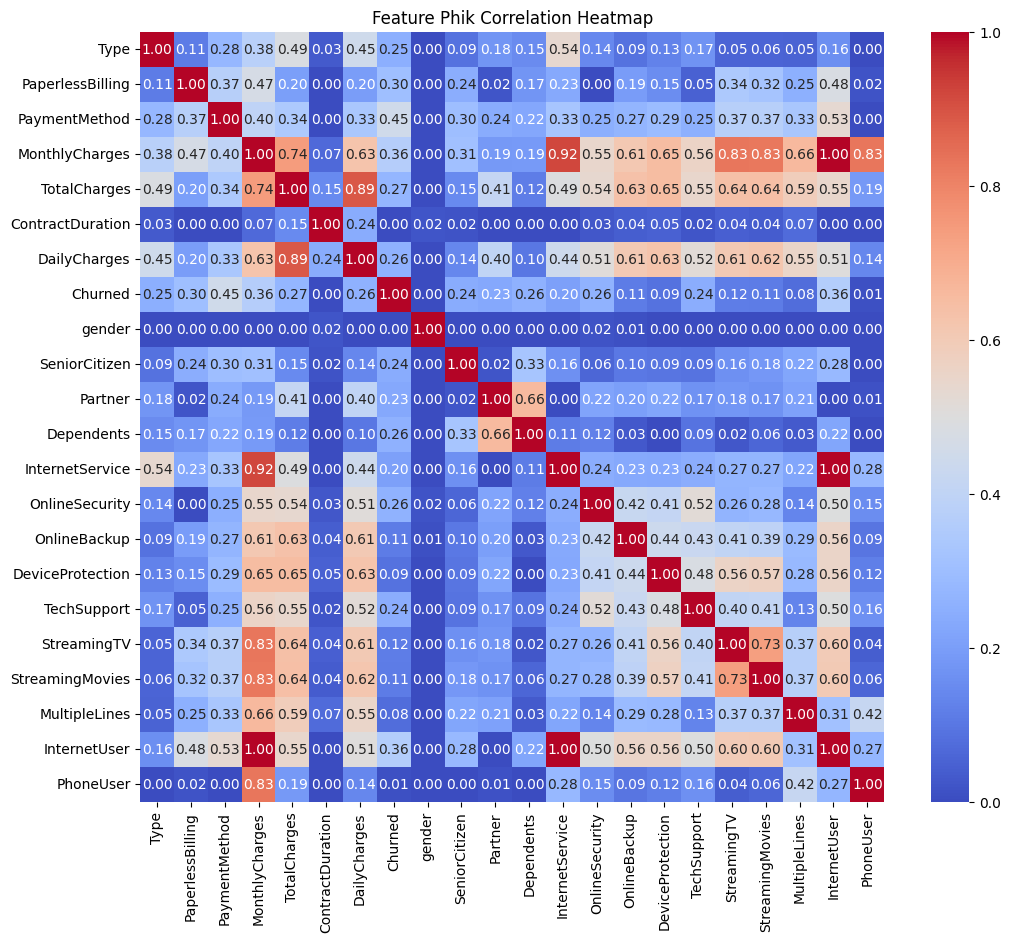

In [ ]:
# Calculating phik correlation
correlation_matrix = data.phik_matrix()

# Visualizing the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Phik Correlation Heatmap")
plt.show()

#### Conclusions:

- The features **ContractDuration, gender, OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies, MultipleLines, and PhoneUser** have either no or insignificant impact on the target variable. We will discard them in the next step.
- The features **Type, PaymentMethod, InternetService, and MonthlyCharges** have the most significant impact on the target variable. There are significant differences in the distribution of the target variable among the values of these features.

#### Removing unnecessary data.

In [ ]:
columns_to_drop = ['ContractDuration', 'gender', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies',
                   'MultipleLines', 'PhoneUser', 'SeniorCitizen', 'Partner']

data.drop(columns=columns_to_drop, inplace=True)

#### Identifying and removing complete duplicates.

In [ ]:
# Displaying the number of duplicates
print(data.duplicated().sum())

207


In [ ]:
# Removing duplicates
data = data.drop_duplicates()

In [ ]:
# Displaying the final result
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6627 entries, 0 to 6833
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              6627 non-null   string 
 1   PaperlessBilling  6627 non-null   string 
 2   PaymentMethod     6627 non-null   string 
 3   MonthlyCharges    6627 non-null   Int64  
 4   TotalCharges      6627 non-null   Int64  
 5   DailyCharges      6627 non-null   Float64
 6   Churned           6627 non-null   Int64  
 7   Dependents        6627 non-null   string 
 8   InternetService   6627 non-null   string 
 9   OnlineSecurity    6627 non-null   string 
 10  TechSupport       6627 non-null   string 
 11  InternetUser      6627 non-null   string 
dtypes: Float64(1), Int64(3), string(8)
memory usage: 698.9 KB


### Preparing data for training various models.

#### Preparing the test and training datasets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['Churned']),
    data.Churned,
    test_size=0.25,
    shuffle=True,
    random_state=SEED,
    stratify=data['Churned'])

categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Dependents', 'InternetService',
                        'OnlineSecurity', 'TechSupport', 'InternetUser']
numerical_features = ['MonthlyCharges', 'DailyCharges', 'TotalCharges']


#### Preparing data for training a Random Forest model.

In [ ]:
# Applying ColumnTransformer
rf_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(), categorical_features),
        ('num', "passthrough", numerical_features)
    ])

X_train_rf = rf_preprocessor.fit_transform(X_train)
X_test_rf = rf_preprocessor.transform(X_test)

### Preparing data for training a CatBoostClassifier model.

In [ ]:
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

#### Preparing data for finding the optimal architecture and training a neural network.

In [ ]:
# Splitting the training data into training and validation sets
X_train_n, X_val, y_train_n, y_val = train_test_split(
    X_train, y_train, test_size=0.25, shuffle=True,
    random_state=SEED, stratify=y_train
)

# Defining the ColumnTransformer
preprocessor_nn = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

# Applying transformations
X_train_n = preprocessor_nn.fit_transform(X_train_n)
X_val = preprocessor_nn.transform(X_val)
X_test = preprocessor_nn.transform(X_test)

# Converting data to tensors
X_train_n_t = torch.FloatTensor(X_train_n.astype('float32'))
X_val_t = torch.FloatTensor(X_val.astype('float32'))
X_test_t = torch.FloatTensor(X_test.astype('float32'))

y_train_n_t = torch.FloatTensor(y_train_n.values).squeeze().type(torch.FloatTensor)
y_val_t = torch.FloatTensor(y_val.values).squeeze().type(torch.FloatTensor)
y_test_t = torch.FloatTensor(y_test.values).squeeze().type(torch.FloatTensor)

## Training various models.

### Tuning hyperparameters and training a Random Forest model.

In [ ]:
%%time

# Applying stratified_kfold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Creating an instance of the classifier
rfc_classifier = RandomForestClassifier(random_state=SEED, class_weight='balanced')

# Defining the parameter grid for tuning
rfc_param_grid = {'n_estimators': list(range(10, 101, 10)),
                  'max_depth': list(range(1, 11))}

# Using GridSearchCV to search for optimal parameters
rfc_grid_search = GridSearchCV(rfc_classifier, param_grid=rfc_param_grid, cv=stratified_kfold, scoring='roc_auc', verbose=1)

# Training the model
rfc_grid_search.fit(X_train_rf, y_train)

# Displaying the best result and best parameters
print("Best parameters found for RandomForestClassifier:", rfc_grid_search.best_params_)
print("Best ROC_AUC score:", rfc_grid_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found for RandomForestClassifier: {'max_depth': 5, 'n_estimators': 100}
Best ROC_AUC score: 0.8308834776612761
CPU times: user 2min 2s, sys: 512 ms, total: 2min 3s
Wall time: 2min 21s


### Tuning hyperparameters and training a CatboostClassifier model.

In [ ]:
%%time

for col in X_train_cb.columns:
    if isinstance(X_train_cb[col].dtype, pd.core.arrays.floating.FloatingDtype):
        X_train_cb[col] = X_train_cb[col].astype('float')

# Create an instance of the classifier
cbc_classifier = CatBoostClassifier(random_state=SEED, verbose=False, auto_class_weights='Balanced',
                                    cat_features=categorical_features)

# Define the parameter grid for tuning
cbc_param_grid = {
    'learning_rate': [0.01, 0.03],
    'iterations': [1000],
    'depth': [5, 6]
}

# Use GridSearchCV to find the optimal parameters
cbc_grid_search = GridSearchCV(estimator=cbc_classifier, param_grid=cbc_param_grid, cv=stratified_kfold, scoring='roc_auc')

# Train the model
cbc_grid_search.fit(X_train_cb, y_train)

# Print the best score and best parameters
print('Best ROC_AUC score:', cbc_grid_search.best_score_)
print('Best parameters:', cbc_grid_search.best_params_)

Best ROC_AUC score: 0.8349750262879319
Best parameters: {'depth': 5, 'iterations': 1000, 'learning_rate': 0.01}
CPU times: user 3min 47s, sys: 21.2 s, total: 4min 8s
Wall time: 2min 39s


### Building a neural network model.


#### Creating a function for training and evaluating the neural network model.

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class BinaryClassifier(nn.Module):
    def __init__(self, layer_structure):
        super(BinaryClassifier, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(15, layer_structure[0]))
        for i in range(len(layer_structure) - 1):
            self.layers.append(nn.Linear(layer_structure[i], layer_structure[i+1]))
        self.layers.append(nn.Linear(layer_structure[-1], 1))

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            if i % 2 == 0:
                x = torch.tanh(self.layers[i](x))
            else:
                x = torch.sigmoid(self.layers[i](x))
        x = torch.sigmoid(self.layers[-1](x))
        return x.squeeze()

# Model training
def train_model(model, X_train_n_t, y_train_n_t, X_val_t, y_val_t, learning_rate=0.003, early_stopping_patience=500,
                weight_decay=1e-3):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    best_roc_auc = float('-inf')
    best_train_roc_auc = float('-inf')
    no_improve_epochs = 0
    epochs = 0

    train_roc_aucs = []
    val_roc_aucs = []

    while True:
        model.train()
        optimizer.zero_grad()
        train_outputs = model(X_train_n_t)
        loss = criterion(train_outputs, y_train_n_t)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            model.eval()
            train_roc_auc = roc_auc_score(y_train_n_t.numpy(), train_outputs.numpy())
            val_outputs = model(X_val_t)
            val_roc_auc = roc_auc_score(y_val_t.numpy(), val_outputs.numpy())

            train_roc_aucs.append(train_roc_auc)
            val_roc_aucs.append(val_roc_auc)

            if val_roc_auc > best_roc_auc:
                best_roc_auc = val_roc_auc
                best_train_roc_auc = train_roc_auc
                no_improve_epochs = 0
            else:
                no_improve_epochs += 1

        if epochs % 200 == 0:
            print(f"Epoch {epochs} - Train ROC_AUC: {train_roc_auc}, Validation ROC_AUC: {val_roc_auc}")

        if no_improve_epochs >= early_stopping_patience:
            print(f'Early stopping at epoch {epochs}')
            break

        epochs += 1

    return model, best_roc_auc, best_train_roc_auc, train_roc_aucs, val_roc_aucs

#### Finding the best neural network architecture in terms of the number of hidden layers and neurons in them with metric output.

In [ ]:
%%time

neurons_per_layer = [32, 16]
max_hidden_layers = 3

best_overall_roc_auc = float('-inf')
best_overall_model_structure = None
best_overall_train_roc_auc = float('-inf')
best_overall_train_roc_aucs = []
best_overall_val_roc_aucs = []

# best_model_path = "/content/best_model.pth"

layer_structures = list(itertools.product(neurons_per_layer, repeat=max_hidden_layers))

for layer_structure in tqdm(layer_structures, desc="Training models", unit="model"):
    model = BinaryClassifier(layer_structure)
    model.apply(init_weights)
    model, best_roc_auc, best_train_roc_auc, train_roc_aucs, val_roc_aucs = train_model(model, X_train_n_t,
                                                                                        y_train_n_t, X_val_t, y_val_t)

    if best_roc_auc > best_overall_roc_auc:
        best_overall_roc_auc = best_roc_auc
        best_overall_model_structure = layer_structure
        best_overall_train_roc_auc = best_train_roc_auc
        best_overall_train_roc_aucs = train_roc_aucs
        best_overall_val_roc_aucs = val_roc_aucs
#         torch.save(model.state_dict(), best_model_path)

# Display only the best metric on the validation stage
print(f"Best architecture: {best_overall_model_structure}")
print(f"Best ROC_AUC score on the validation stage: {best_overall_roc_auc}")

Training models:   0%|          | 0/8 [00:00<?, ?model/s]

Epoch 0 - Train ROC_AUC: 0.4906808746609115, Validation ROC_AUC: 0.5238685333926801
Epoch 200 - Train ROC_AUC: 0.8371277520495182, Validation ROC_AUC: 0.8243048671104187
Epoch 400 - Train ROC_AUC: 0.8425580384575034, Validation ROC_AUC: 0.8287659915970355
Epoch 600 - Train ROC_AUC: 0.8461853483806183, Validation ROC_AUC: 0.8291402809530555
Epoch 800 - Train ROC_AUC: 0.8484150892495842, Validation ROC_AUC: 0.8289716821440375
Epoch 1000 - Train ROC_AUC: 0.8494263597260314, Validation ROC_AUC: 0.8286311125498209


Training models:  12%|█▎        | 1/8 [00:12<01:29, 12.80s/model]

Early stopping at epoch 1139
Epoch 0 - Train ROC_AUC: 0.6617547547322513, Validation ROC_AUC: 0.6791480364982702
Epoch 200 - Train ROC_AUC: 0.8342775354825173, Validation ROC_AUC: 0.8237788388262823
Epoch 400 - Train ROC_AUC: 0.8393676093700821, Validation ROC_AUC: 0.8273194138156609
Epoch 600 - Train ROC_AUC: 0.842688428278105, Validation ROC_AUC: 0.8289312184298729
Epoch 800 - Train ROC_AUC: 0.8463472116061928, Validation ROC_AUC: 0.8292313243099252
Epoch 1000 - Train ROC_AUC: 0.8484915246616609, Validation ROC_AUC: 0.8283478665506707
Epoch 1200 - Train ROC_AUC: 0.8502379239542586, Validation ROC_AUC: 0.8272384863873321


Training models:  25%|██▌       | 2/8 [00:24<01:14, 12.39s/model]

Early stopping at epoch 1246
Epoch 0 - Train ROC_AUC: 0.355208099156213, Validation ROC_AUC: 0.46032364227379097
Epoch 200 - Train ROC_AUC: 0.8393781005050732, Validation ROC_AUC: 0.8265303713894565
Epoch 400 - Train ROC_AUC: 0.8457919308184583, Validation ROC_AUC: 0.8303474484256244
Epoch 600 - Train ROC_AUC: 0.8507658528543381, Validation ROC_AUC: 0.8268641970313121
Epoch 800 - Train ROC_AUC: 0.8532820391768954, Validation ROC_AUC: 0.8243992824434689


Training models:  38%|███▊      | 3/8 [00:34<00:56, 11.27s/model]

Early stopping at epoch 918
Epoch 0 - Train ROC_AUC: 0.5457040675629093, Validation ROC_AUC: 0.5560236982485955
Epoch 200 - Train ROC_AUC: 0.8363356713577028, Validation ROC_AUC: 0.8245240455621422
Epoch 400 - Train ROC_AUC: 0.8414433553647168, Validation ROC_AUC: 0.8279634612661096
Epoch 600 - Train ROC_AUC: 0.8456634144148195, Validation ROC_AUC: 0.8295718939041414
Epoch 800 - Train ROC_AUC: 0.849758329211816, Validation ROC_AUC: 0.8285636730262137
Epoch 1000 - Train ROC_AUC: 0.8518908397404193, Validation ROC_AUC: 0.8256738894396449


Training models:  50%|█████     | 4/8 [00:44<00:42, 10.75s/model]

Early stopping at epoch 1118
Epoch 0 - Train ROC_AUC: 0.7898524496800204, Validation ROC_AUC: 0.7756270189707382
Epoch 200 - Train ROC_AUC: 0.8378512656804998, Validation ROC_AUC: 0.8238901140402345
Epoch 400 - Train ROC_AUC: 0.8432770558877749, Validation ROC_AUC: 0.8281927556463741
Epoch 600 - Train ROC_AUC: 0.8510341261633918, Validation ROC_AUC: 0.8267630377459014
Epoch 800 - Train ROC_AUC: 0.8546854158236291, Validation ROC_AUC: 0.8257177251299896


Training models:  62%|██████▎   | 5/8 [00:54<00:31, 10.45s/model]

Early stopping at epoch 962
Epoch 0 - Train ROC_AUC: 0.5484162132997618, Validation ROC_AUC: 0.5083270951773997
Epoch 200 - Train ROC_AUC: 0.836366770079283, Validation ROC_AUC: 0.8235360565412966
Epoch 400 - Train ROC_AUC: 0.842392053714611, Validation ROC_AUC: 0.8275621961006467
Epoch 600 - Train ROC_AUC: 0.8485938132278223, Validation ROC_AUC: 0.8288772668109872
Epoch 800 - Train ROC_AUC: 0.8526819837237535, Validation ROC_AUC: 0.8270732595544944
Epoch 1000 - Train ROC_AUC: 0.8556018914017657, Validation ROC_AUC: 0.8262403814379455


Training models:  75%|███████▌  | 6/8 [01:05<00:21, 10.58s/model]

Early stopping at epoch 1067
Epoch 0 - Train ROC_AUC: 0.2580736777423077, Validation ROC_AUC: 0.2743288081412993
Epoch 200 - Train ROC_AUC: 0.8385017160499378, Validation ROC_AUC: 0.8262875891044706
Epoch 400 - Train ROC_AUC: 0.8429555775369811, Validation ROC_AUC: 0.8292414402384661
Epoch 600 - Train ROC_AUC: 0.8460954243664104, Validation ROC_AUC: 0.8296764251657326
Epoch 800 - Train ROC_AUC: 0.8501082835004422, Validation ROC_AUC: 0.8287761075255764
Epoch 1000 - Train ROC_AUC: 0.853252813872278, Validation ROC_AUC: 0.8262201495808634


Training models:  88%|████████▊ | 7/8 [01:14<00:10, 10.21s/model]

Early stopping at epoch 1108
Epoch 0 - Train ROC_AUC: 0.2963985432309698, Validation ROC_AUC: 0.3297202608560773
Epoch 200 - Train ROC_AUC: 0.8384350224060668, Validation ROC_AUC: 0.8242745193247955
Epoch 400 - Train ROC_AUC: 0.8443435921646208, Validation ROC_AUC: 0.8279836931231918
Epoch 600 - Train ROC_AUC: 0.8490065269846979, Validation ROC_AUC: 0.8281354320513079
Epoch 800 - Train ROC_AUC: 0.8535302669244488, Validation ROC_AUC: 0.8249961222273925
Epoch 1000 - Train ROC_AUC: 0.855850306491015, Validation ROC_AUC: 0.8226087630916975


Training models: 100%|██████████| 8/8 [01:25<00:00, 10.66s/model]

Early stopping at epoch 1032
Best architecture: (32, 16, 32)
Best ROC_AUC score on the validation stage: 0.8305801147820691
CPU times: user 1min 23s, sys: 492 ms, total: 1min 24s
Wall time: 1min 25s


### Conclusions from the training of models.


- All models showed decent results in terms of the ROC_AUC metric.
- The CatBoost model demonstrated the best performance.

## Testing the best model and demonstrating its performance.

# Checking the model's performance on the test dataset

In [ ]:
# Using the best model from GridSearch
best_model = cbc_grid_search.best_estimator_

# Predicting probabilities for the test dataset
y_test_pred_proba = best_model.predict_proba(X_test_cb)[:, 1]

# Calculating ROC AUC
roc_auc_score_test = roc_auc_score(y_test, y_test_pred_proba)
print(f'ROC AUC on the test dataset: {roc_auc_score_test}')

ROC AUC on the test dataset: 0.8638009135535718


### Building a confusion matrix. Calculating and displaying precision and recall values.

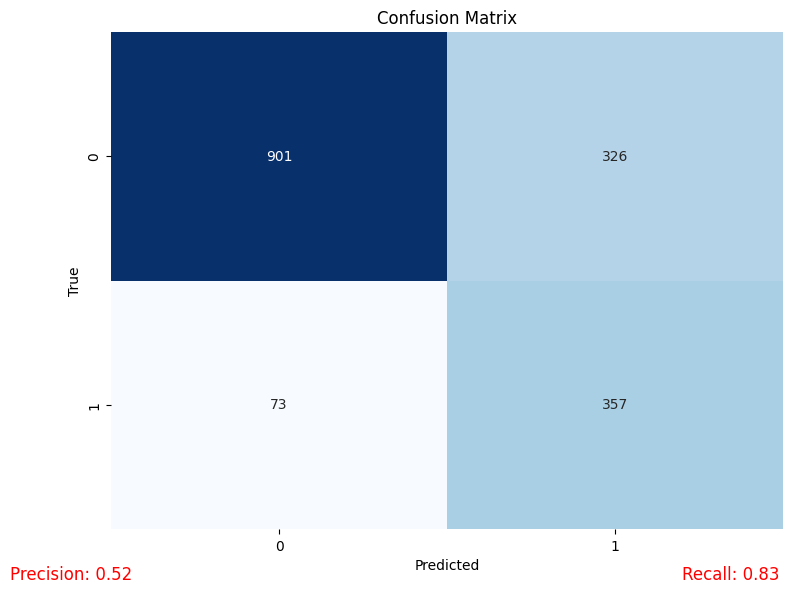

In [ ]:
# True and predicted values
y_true = y_test_t.numpy()
y_pred = best_model.predict(X_test_cb)

# Building the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Calculating precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

# Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Adding text for precision and recall
plt.text(-0.3, 2.2, f'Precision: {precision:.2f}', fontsize=12, color='red')
plt.text(1.7, 2.2, f'Recall: {recall:.2f}', fontsize=12, color='red')

plt.tight_layout()
plt.show()

### Analyzing the importance of features affecting customer churn.

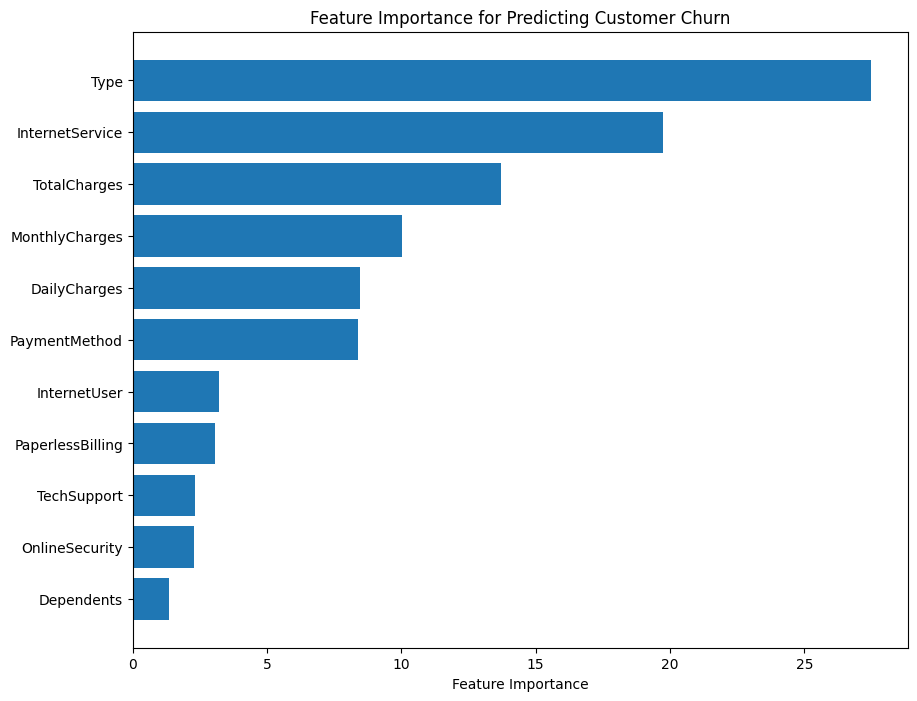

In [ ]:
### Visualizing Feature Importance for Predicting Customer Churn

feature_importances = best_model.get_feature_importance()
feature_names = X_train.columns
# Sort features by importance
sorted_indices = np.argsort(feature_importances)

# Create a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [feature_names[i] for i in sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Predicting Customer Churn')
plt.show()

### The most important features for predicting customer churn are:
- Payment Type
- Payment Method
- Total Charges
- Monthly Charges

### Analyzing the relationship between the most important features and the target variable.


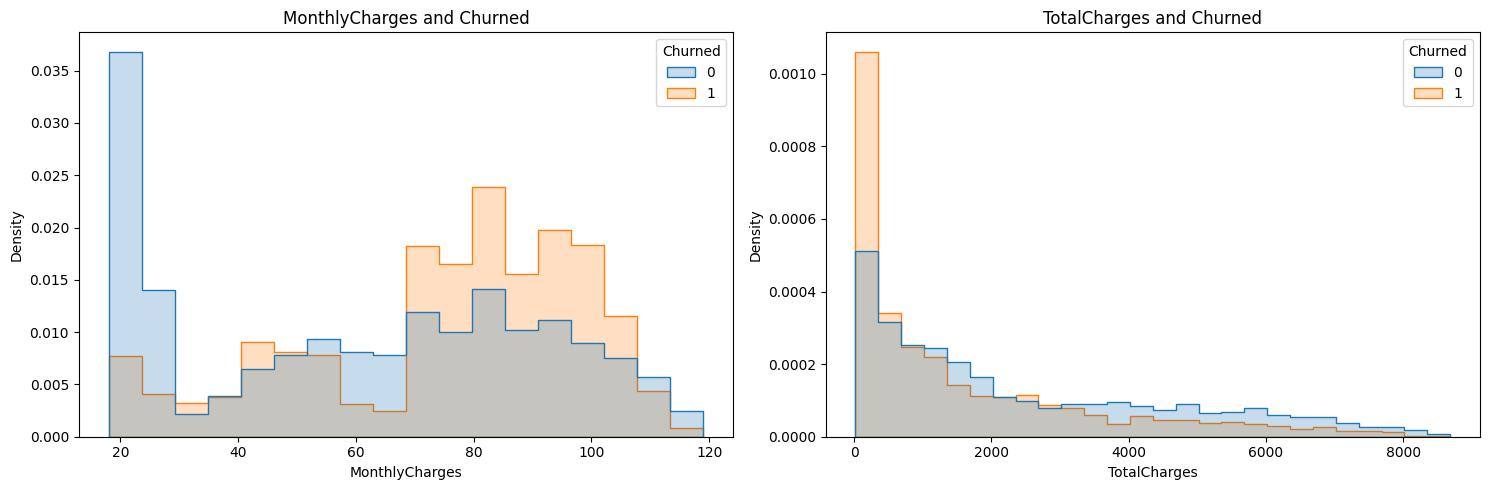

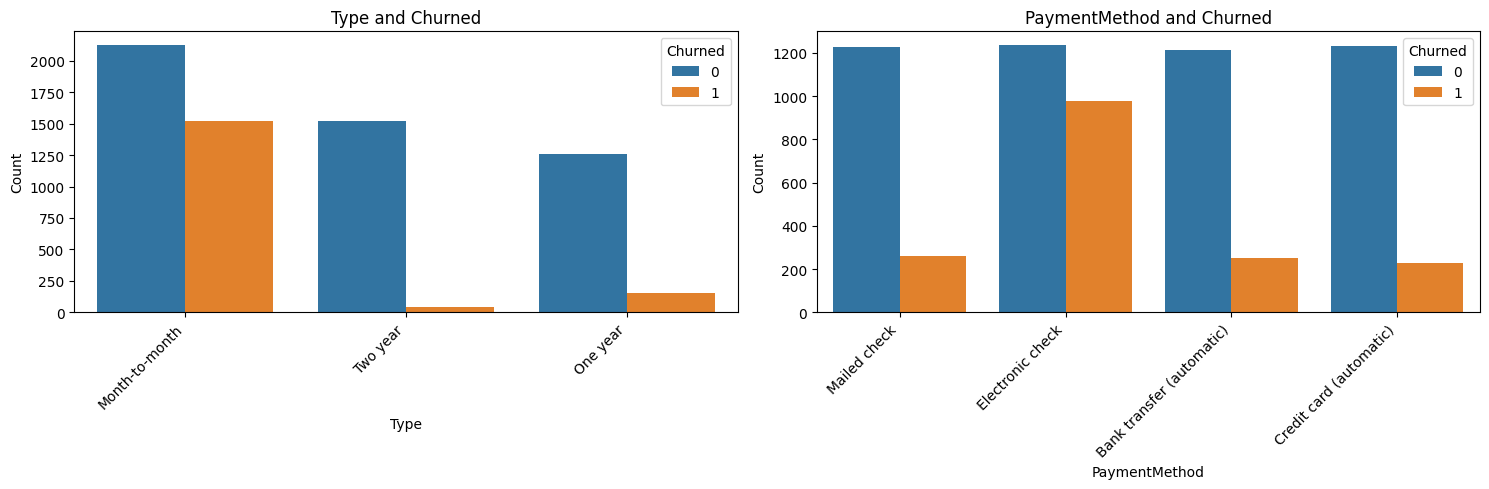

In [ ]:
# Only numerical features
numerical_features = ['MonthlyCharges', 'TotalCharges']

fig, axes = plt.subplots(1, len(numerical_features), figsize=(15, 5))

for i, feature in enumerate(numerical_features):
    ax = axes[i]
    sns.histplot(data=data, x=feature, hue='Churned', element='step', stat='density', common_norm=False, ax=ax)
    ax.set_title(f'{feature} and Churned')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()

# Now, all categorical features
categorical_features = ['Type', 'PaymentMethod']

rows = math.ceil(len(categorical_features) / 2)
fig, axes = plt.subplots(rows, 2, figsize=(15, rows * 5))

# Ensure axes is always two-dimensional
axes = np.array(axes).reshape(rows, -1)

for i, feature in enumerate(categorical_features):
    ax = axes[i // 2, i % 2]
    sns.countplot(data=data, x=feature, hue='Churned', ax=ax)
    ax.set_title(f'{feature} and Churned')
    ax.set_ylabel('Count')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

**Conclusions:**
- **Total Charges:** Customers with significant total charges (over 400 USD) are less likely to churn.
- **Monthly Charges:** Customers with monthly charges exceeding 70 USD are more likely to churn.
- **Payment Type:** Paying for services annually or biannually significantly reduces the risk of customer churn.
- **Payment Method:** Customers with automatic payment methods are less likely to leave the provider.

## General conclusion.

**Business Recommendations for the Client:**

- Offer special conditions for customers planning to switch providers, with payment for one or two years in advance. However, the monthly expenses for the customer should not exceed 70 USD.
- Gradually transition all customers to automatic payment for services to reduce churn.